In [1]:
# Import packages
import gymnasium as gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import torch.nn.functional as F

# Set up lunar lander environment
ENV = gym.make('LunarLander-v2')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [2]:
class ActorCritic(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim, dropout = 0.1):
      # Define actor and critic nets
        super().__init__()

        self.actor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.PReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.PReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.PReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim3, output_dim)
        )

        self.critic = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.PReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.PReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.PReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim3, 1)
        )

    def forward(self, x):
        """Run input through actor critic model"""
        actor_out = self.actor(x)
        critic_out = self.critic(x)
        return actor_out, critic_out

In [3]:
def calculate_discounted_rewards(rewards, gamma = 0.99, normalize = True):
  """Calculate forward discounted rewards so model can learn values of actions and states wholistically"""
  discounted_rewards = []

  # Calculate discounted rewards by iterating through the list backwards
  _r = 0
  for r in reversed(rewards):
      _r = r + _r * gamma
      discounted_rewards.insert(0, _r)

  discounted_rewards = torch.tensor(discounted_rewards)

  if normalize:
      drm = discounted_rewards.mean()
      drstd = discounted_rewards.std() + 0.00001
      discounted_rewards = (discounted_rewards - drm) / drstd

  return discounted_rewards

In [4]:
def calculate_advantages(discounted_rewards, state_values, normalize = True):
  """Find out the advantages of actions against expected values of the state"""
  advantages = discounted_rewards.to(DEVICE) - state_values

  if normalize:
      am = advantages.mean()
      astd = advantages.std() + 0.00001
      advantages = (advantages - am) / astd

  return advantages

In [5]:
def step_actor_critic(actor_critic, states, actions, log_prob_actions, advantages, rewards, optimizer, steps, clip, entropy_coef):
  """Run PPO training step"""
  total_model_loss = 0
  total_value_loss = 0
  total_entropy = 0

  states = states.detach().to(DEVICE)
  actions = actions.detach().to(DEVICE)
  log_prob_actions = log_prob_actions.detach().to(DEVICE)
  advantages = advantages.detach().to(DEVICE)
  rewards = rewards.detach().to(DEVICE)

  # Run PPO update
  for i in range(steps):
    action_out, value_out = actor_critic(states)
    value_out = value_out.squeeze(-1)
    action_prob = F.softmax(action_out, dim = -1)
    dist = Categorical(action_prob)
    new_log_prob_actions = dist.log_prob(actions)

    model_ratio = (new_log_prob_actions - log_prob_actions).exp()
    model_loss_1 = model_ratio * advantages
    model_loss_2 = torch.clamp(model_ratio, min = 1.0 - clip, max = 1.0 + clip) * advantages
    model_loss = -torch.min(model_loss_1, model_loss_2).mean()

    value_loss = nn.SmoothL1Loss(reduction = 'mean')(rewards, value_out)

    entropy = dist.entropy().mean() * entropy_coef

    # Pass losses and entropy backward
    optimizer.zero_grad()
    entropy.backward(retain_graph = True)
    model_loss.backward()
    value_loss.backward()
    optimizer.step()

    # Calculate this session losses and entropy to print out later
    total_model_loss += model_loss.item()
    total_value_loss += value_loss.item()
    total_entropy += entropy.item()

  return total_model_loss / steps, total_value_loss / steps, total_entropy

In [6]:
def run_game(env, agent, train = True):
  """Run the gym game and store relevant values, depending on if training or evaluating"""
  done = False
  truncated = False
  total_reward = 0
  total_steps = 0
  state, _ = env.reset()

  if train:
    agent.train()

    states = []
    actions = []
    log_prob_actions = []
    values = []
    rewards = []

    while not done and not truncated:
      # Run an episode and return state, action, and reward stuff
      state = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
      states.append(state)

      # Sample actions based on probability
      action_out, value_out = agent(state)
      action_prob = F.softmax(action_out, dim = -1)
      dist = Categorical(action_prob)
      action = dist.sample()
      log_prob_action = dist.log_prob(action)

      state, reward, done, truncated, _ = env.step(action.item())

      actions.append(action)
      log_prob_actions.append(log_prob_action)
      values.append(value_out)
      rewards.append(reward)

      total_reward += reward
      total_steps += 1

    return torch.cat(states), torch.cat(actions), torch.cat(log_prob_actions), torch.cat(values).squeeze(-1), rewards, total_reward, total_steps

  else:
    with torch.no_grad():
      agent.eval()

      while not done and not truncated:
        # Run an episode and return reward stuff
        state = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)

        # Choose the best action
        action_out, value_out = agent(state)
        action_prob = F.softmax(action_out, dim = -1)
        action = torch.argmax(action_prob, dim = -1)
        state, reward, done, truncated, _ = env.step(action.item())

        total_reward += reward
        total_steps += 1

      return total_reward, total_steps

In [7]:
STEPS = 10
ENTROPY_COEF = 0.0001
CLIP = 0.2

def train(env, actor_critic, optimizer, steps = STEPS, clip = CLIP, entropy_coef = ENTROPY_COEF):
  """Run PPO training"""

  states, actions, log_prob_actions, values, rewards, total_reward, total_steps = run_game(env, actor_critic)

  discounted_rewards = calculate_discounted_rewards(rewards)
  advantages = calculate_advantages(discounted_rewards, values)

  model_loss, value_loss, entropy = step_actor_critic(actor_critic, states, actions, log_prob_actions, advantages, discounted_rewards, optimizer, steps, clip, entropy_coef)

  return total_reward, model_loss, value_loss, total_steps, entropy

In [8]:
# Define learning agent
actor_critic = ActorCritic(8, 128, 256, 128, 4).to(DEVICE)

def initialize_weights(layer):
    "Apply Xavier Normalization to layers when making new model"
    if type(layer) == nn.Linear:
        torch.nn.init.xavier_normal_(layer.weight)
        layer.bias.data.fill_(0)
    return

# Initialize weights of learning agent
actor_critic.apply(initialize_weights)

# Define the optimizer
optimizer1 = optim.Adam(actor_critic.parameters(), lr = 0.0001)
optimizer2 = optim.SGD(actor_critic.parameters(), lr = 0.0001, momentum = 0.9)

In [9]:
rewards = []
model_losses = []
value_losses = []
entropies = []
test_rewards = []
ADAM_EPISODES = 3_001 # Max number of ADAM episodes, usually reach solved state before this
SGD_EPISODES = 1_001 # SGD steps to run afterwards and search for best generalized solution
SOLVED = 0

for i in range(ADAM_EPISODES):
  # Run Adam first
  optimizer = optimizer1

  # Train the model
  reward, model_loss, value_loss, total_steps, entropy = train(ENV, actor_critic, optimizer)
  rewards.append(reward)
  model_losses.append(model_loss)
  value_losses.append(value_loss)
  entropies.append(entropy)

  # Evaluate the model
  test_reward, test_steps = run_game(ENV, actor_critic, train = False)
  test_rewards.append(test_reward)

  if i % 25 == 0:
    print(f'Adam episode: {i} reward: {test_reward} total_steps: {test_steps} model_loss: {model_loss} value_loss: {value_loss} entropy: {entropy}')

  if sum(test_rewards[-20:]) >= 200 * 20 and SOLVED == 0:
    print(f'Lunar Lander solved at {i} steps (average 200 test score across 20 episodes)')
    SOLVED = i
    break

for i in range(i, i + SGD_EPISODES):
  # Run SGD next since it may reach better generalized convergence
  optimizer = optimizer2

  # Train the model
  reward, model_loss, value_loss, total_steps, entropy = train(ENV, actor_critic, optimizer)
  rewards.append(reward)
  model_losses.append(model_loss)
  value_losses.append(value_loss)
  entropies.append(entropy)

  # Evaluate the model
  test_reward, test_steps = run_game(ENV, actor_critic, train = False)
  test_rewards.append(test_reward)

  if i % 25 == 0:
    print(f'SGD episode: {i} reward: {test_reward} total_steps: {test_steps} model_loss: {model_loss} value_loss: {value_loss} entropy: {entropy}')

Adam episode: 0 reward: -125.69168740037057 total_steps: 67 model_loss: -0.010671421744002514 value_loss: 0.46529395192650724 entropy: 0.0013717602414544672
Adam episode: 25 reward: -260.77201914760764 total_steps: 97 model_loss: 0.00644056035902976 value_loss: 0.697208276423334 entropy: 0.001323330434388481
Adam episode: 50 reward: -335.92867208692735 total_steps: 81 model_loss: -0.0073895684160791095 value_loss: 0.3039256735415224 entropy: 0.001189352507935837
Adam episode: 75 reward: -1124.55546441073 total_steps: 190 model_loss: 0.0043741413832063605 value_loss: 0.4776402836442962 entropy: 0.0011039451928809285
Adam episode: 100 reward: -1107.887217205308 total_steps: 510 model_loss: -5.039101184891665e-06 value_loss: 0.09265574887096235 entropy: 0.0011070874679717235
Adam episode: 125 reward: -803.3789490268886 total_steps: 475 model_loss: 0.00821336450087505 value_loss: 0.4649828384470699 entropy: 0.001022301148623228
Adam episode: 150 reward: -310.2854738509773 total_steps: 369 

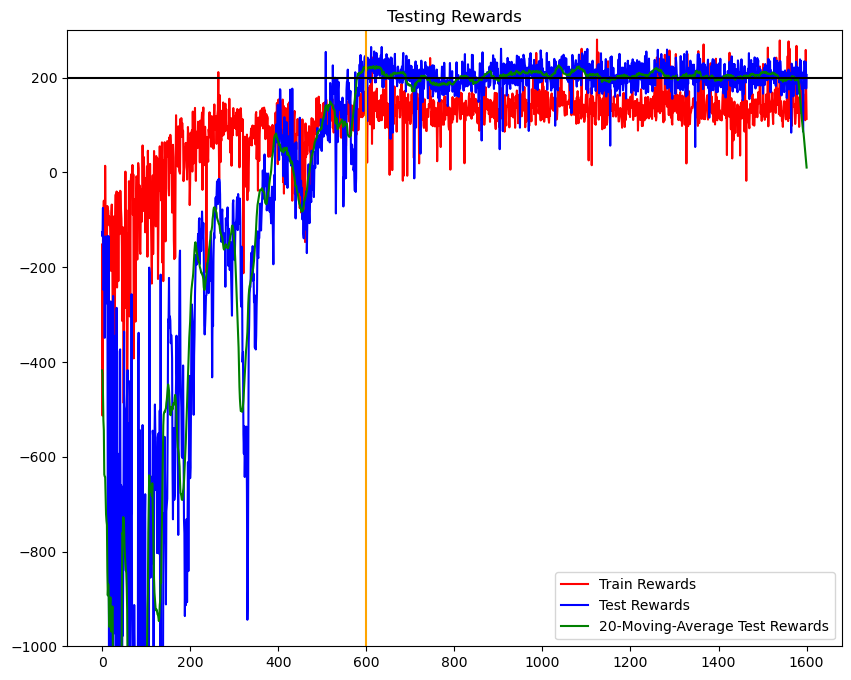

In [12]:
# Plot train and test rewards, as well as 20 testing moving average rewards.
# Include relevant reference lines.
moving_average_rewards = []
for i in range(len(test_rewards)):
    moving_average_rewards.append(sum(test_rewards[i:i + 20]) / 20)
plt.figure(figsize = (10, 8))
plt.plot(rewards, color = 'red', label = 'Train Rewards')
plt.plot(test_rewards, color = 'blue', label = 'Test Rewards')
plt.plot(moving_average_rewards, color = 'green', label = '20-Moving-Average Test Rewards')
plt.axvline(SOLVED, color = 'orange')
plt.axhline(200, color = 'black')
plt.ylim(-1000, 300)
plt.legend()
plt.title('Testing Rewards')
plt.show()

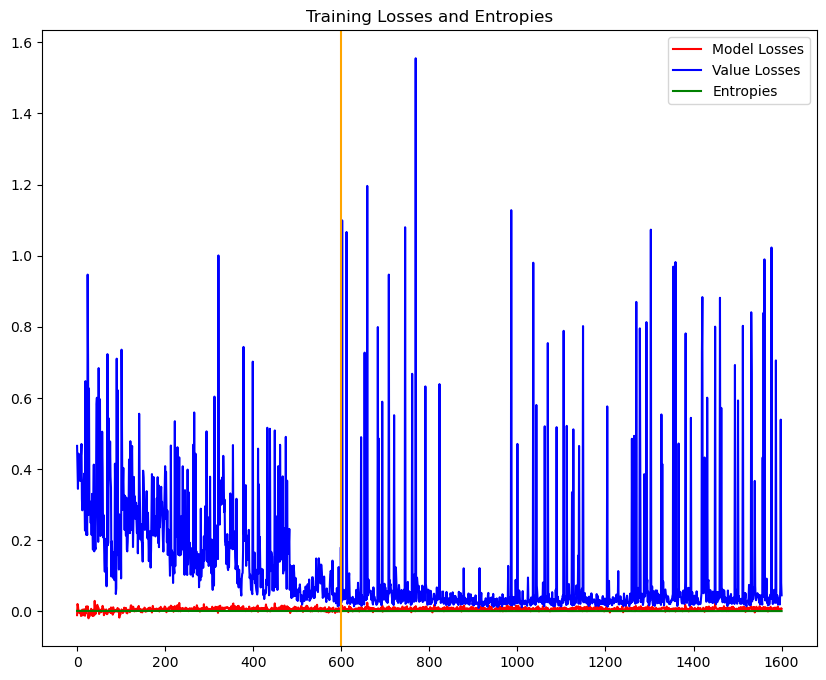

In [14]:
plt.figure(figsize = (10, 8))
plt.plot(model_losses, color = 'red', label = 'Model Losses')
plt.plot(value_losses, color = 'blue', label = 'Value Losses')
plt.plot(entropies, color = 'green', label = 'Entropies')
plt.axvline(SOLVED, color = 'orange')
plt.legend()
plt.title('Training Losses and Entropies')
plt.show()

In [53]:
# Save videos of the agent playing lunar lander
env = gym.make('LunarLander-v2', render_mode='rgb_array_list')
dummy_agent = ActorCritic(8, 128, 256, 128, 4)
final_agent = actor_critic
final_agent.to('cpu')
from gymnasium.utils.save_video import save_video
state, _ = env.reset()
step_starting_index = 0
episode_index = 0
for agent in [dummy_agent, final_agent]: 
   terminated = 0
   truncated = 0
   while not terminated or truncated:
      state = torch.FloatTensor(state).unsqueeze(0)
      action_out, value_out = agent(state)
      action_prob = F.softmax(action_out, dim = -1)
      action = torch.argmax(action_prob, dim = -1)
      state, _, terminated, truncated, _ = env.step(action.item())
   save_video(
      env.render(),
      "videos",
      fps=env.metadata["render_fps"],
      step_starting_index=step_starting_index,
      episode_index=episode_index
   )
   step_starting_index = step_index + 1
   episode_index += 1
   env.reset()
env.close()

# Convert videos to gifs
from moviepy.editor import VideoFileClip
for mp4 in ('videos/rl-video-episode-0.mp4', 'videos/rl-video-episode-1.mp4'):
   clip = VideoFileClip(mp4)
   clip.write_gif(mp4[:-3]+'gif', fps = 20)


MoviePy - Building file videos/rl-video-episode-0.gif with imageio.


MoviePy - Building file videos/rl-video-episode-1.gif with imageio.
